In [1]:
#baseline BERT with CNN, LSTM CLSTM, imbalanced data
#Final sheet, lets make it look cleaner by ingoring the warnings
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import time
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
#Setting default to GPU, as BERT needs more computation power
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
embed_size = 768 ##
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 30 # max number of words in a question to use

In [4]:
#Load the comibed and processed imbalance data
data=pd.read_csv('../input/crisisnlpcp/CrisisNLP_CP.csv')
data.head(5)

,label,text
0,infrastructure_and_utilities_damage,solar lamps public light electric poles solar ...
1,other_useful_information,another earthquake registered magnitude
2,other_useful_information,big show running cause massive earthquake noth...
3,infrastructure_and_utilities_damage,alaska airlines halts flights la cabo san luca...
4,other_useful_information,news update northern experiences powerful eart...


In [5]:
#randomize the data
np.random.seed(42)
data = data.sample(frac=1)
data = data.reset_index(drop=True)

In [6]:
#do a test train split 80 - 20
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data['text'].astype(str), data['label'],
                                                    stratify=data['label'], 
                                                    test_size=0.20)

In [7]:
#Print the size of the data
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (14664,)
Test shape :  (3666,)


In [8]:
#Initialize BERT
import transformers
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [9]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights)

In [10]:
def tokenize_text(X, max_seq):
    return [tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in X]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])

In [11]:
test_X=tokenize_text(test_X, max_len)
train_X=tokenize_text(train_X, max_len)
test_X=pad_text(test_X, max_len)
train_X=pad_text(train_X, max_len)

In [13]:
#transform labels into numericals
le = LabelEncoder()

train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [14]:
#Print class information 
le.classes_

array(['caution_and_advice', 'displaced_people_and_evacuations',
       'donation_needs_or_offers_or_volunteering_services',
       'infrastructure_and_utilities_damage', 'injured_or_dead_people',
       'missing_trapped_or_found_people', 'not_related_or_irrelevant',
       'other_useful_information', 'sympathy_and_emotional_support'],
      dtype=object)

In [15]:
#Function to test and train the model
def batch_run(n,model):
    n_epochs = n
    model = model
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    model.cuda()

    # Load train and test in CUDA Memory
    x_train = torch.tensor(train_X, dtype=torch.long).cuda()
    y_train = torch.tensor(train_y, dtype=torch.long).cuda()
    x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
    y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    train_loss = []
    valid_loss = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Set model to train configuration
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        # Set model to validation configuration -Doesn't get trained here
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

        # Check Accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                    epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    return train_loss,valid_loss,val_preds

In [16]:
#Function to plot graph for train and valid loss
def plot_graph(epochs,train_loss,valid_loss):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [17]:
#Function to print classification report and plot confusion matrix graph
def conf_matrix(val_preds):
    y_true = [le.classes_[x] for x in test_y]
    y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
    print (classification_report(y_true, y_pred))
    skplt.metrics.plot_confusion_matrix(
        y_true, 
        y_pred,
        figsize=(5,5),x_tick_rotation=90)

In [18]:
#Model1 - CNN
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        drp = 0.2
        n_classes = len(le.classes_)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(drp)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        with torch.no_grad():
            x = bert(x)[0] 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [19]:
#Get Model1-CNN information 
print(CNN_Text())
print (sum([param.nelement() for param in CNN_Text().parameters()]))

CNN_Text(
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=96, out_features=9, bias=True)
)
222153


In [20]:
#Model2-BiLSTM 
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.2
        n_classes = len(le.classes_)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        with torch.no_grad():
            h_embedding = bert(x)[0]
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [21]:
#Get Model2-BiLSTM information 
print(BiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

BiLSTM(
  (lstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
444041


In [24]:
#Model3-CBiLSTM 
class CBiLSTM(nn.Module):
    
    def __init__(self):
        super(CBiLSTM, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        n_classes = len(le.classes_)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
                
        self.hidden_size = 64
        drp = 0.1
        self.lstm = nn.LSTM(96, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        with torch.no_grad():
            x = bert(x)[0]
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = x.unsqueeze(1)
        
        h_lstm, _ = self.lstm(x)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [25]:
#Get Model3-CBiLSTM information
print(CBiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

CBiLSTM(
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 768), stride=(1, 1))
  )
  (lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
444041


In [26]:
batch_size = 128 # how many samples to process at once
n_epochs=10
model_name1=CNN_Text()
model_name2=BiLSTM()
model_name3=CBiLSTM()

In [27]:
#Run the model1
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name1)

Epoch 1/10 	 loss=176.2393 	 val_loss=135.7311  	 val_acc=0.6530  	 time=17.37s
Epoch 2/10 	 loss=129.4331 	 val_loss=126.2399  	 val_acc=0.6740  	 time=17.26s
Epoch 3/10 	 loss=113.7412 	 val_loss=118.2386  	 val_acc=0.6885  	 time=17.23s
Epoch 4/10 	 loss=102.9033 	 val_loss=118.5782  	 val_acc=0.6879  	 time=17.23s
Epoch 5/10 	 loss=94.3247 	 val_loss=114.8725  	 val_acc=0.6975  	 time=17.21s
Epoch 6/10 	 loss=85.7889 	 val_loss=117.0834  	 val_acc=0.6953  	 time=17.28s
Epoch 7/10 	 loss=77.0699 	 val_loss=118.8894  	 val_acc=0.6939  	 time=17.24s
Epoch 8/10 	 loss=70.1655 	 val_loss=119.9835  	 val_acc=0.6844  	 time=17.23s
Epoch 9/10 	 loss=63.2670 	 val_loss=121.0408  	 val_acc=0.6948  	 time=17.29s
Epoch 10/10 	 loss=57.3615 	 val_loss=119.7536  	 val_acc=0.7013  	 time=17.23s


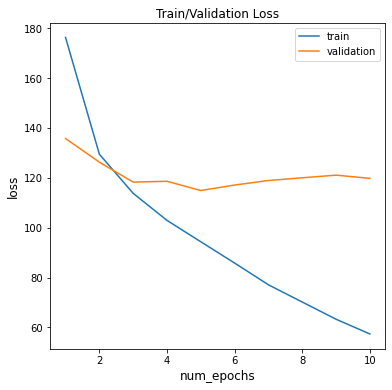

In [28]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.57      0.39      0.46       208
                 displaced_people_and_evacuations       0.70      0.52      0.60       114
donation_needs_or_offers_or_volunteering_services       0.70      0.77      0.73       596
              infrastructure_and_utilities_damage       0.69      0.60      0.64       283
                           injured_or_dead_people       0.91      0.88      0.89       545
                  missing_trapped_or_found_people       0.59      0.43      0.50        82
                        not_related_or_irrelevant       0.65      0.59      0.62       429
                         other_useful_information       0.65      0.72      0.69      1025
                   sympathy_and_emotional_support       0.70      0.77      0.73       384

                                         accuracy                           0.70      36

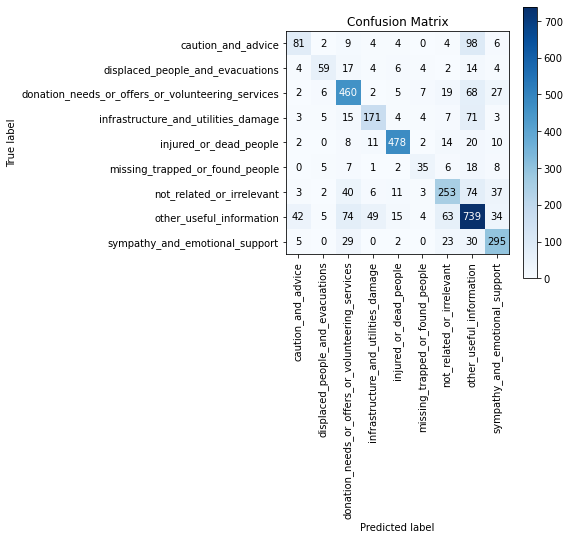

In [29]:
conf_matrix(val_preds)

In [30]:
#Run the model2
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name2)

Epoch 1/10 	 loss=204.8458 	 val_loss=160.7304  	 val_acc=0.5777  	 time=17.78s
Epoch 2/10 	 loss=146.2326 	 val_loss=135.8009  	 val_acc=0.6410  	 time=17.76s
Epoch 3/10 	 loss=124.5684 	 val_loss=126.4340  	 val_acc=0.6661  	 time=17.78s
Epoch 4/10 	 loss=111.0231 	 val_loss=120.9661  	 val_acc=0.6852  	 time=17.76s
Epoch 5/10 	 loss=101.0249 	 val_loss=119.5349  	 val_acc=0.6888  	 time=17.75s
Epoch 6/10 	 loss=90.4796 	 val_loss=119.5552  	 val_acc=0.6918  	 time=17.88s
Epoch 7/10 	 loss=79.9382 	 val_loss=120.8844  	 val_acc=0.6915  	 time=17.74s
Epoch 8/10 	 loss=69.1676 	 val_loss=130.6795  	 val_acc=0.6849  	 time=17.77s
Epoch 9/10 	 loss=60.7563 	 val_loss=138.7950  	 val_acc=0.6773  	 time=17.77s
Epoch 10/10 	 loss=50.7884 	 val_loss=147.6979  	 val_acc=0.6710  	 time=17.74s


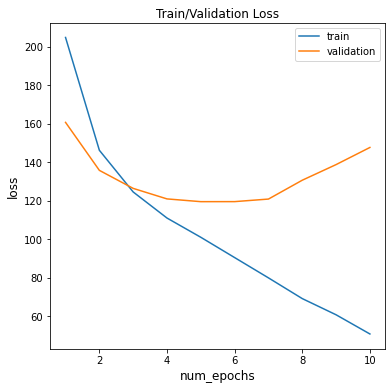

In [31]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.57      0.35      0.44       208
                 displaced_people_and_evacuations       0.64      0.41      0.50       114
donation_needs_or_offers_or_volunteering_services       0.66      0.79      0.72       596
              infrastructure_and_utilities_damage       0.67      0.62      0.64       283
                           injured_or_dead_people       0.87      0.86      0.87       545
                  missing_trapped_or_found_people       0.56      0.18      0.28        82
                        not_related_or_irrelevant       0.48      0.67      0.56       429
                         other_useful_information       0.68      0.65      0.66      1025
                   sympathy_and_emotional_support       0.74      0.66      0.70       384

                                         accuracy                           0.67      36

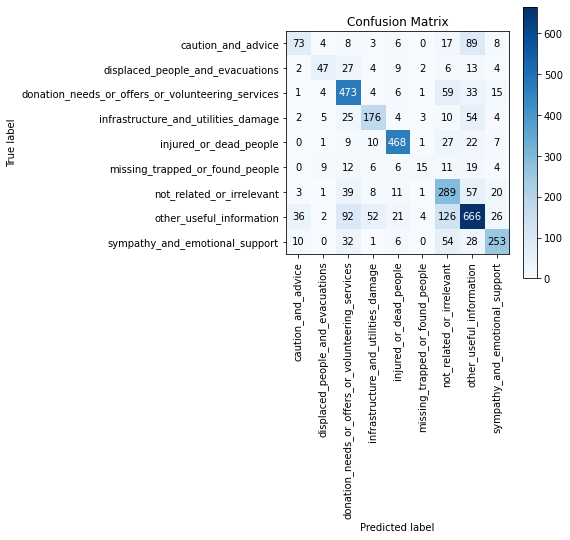

In [32]:
conf_matrix(val_preds)

In [33]:
#Run the model3
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name3)

Epoch 1/10 	 loss=208.4930 	 val_loss=154.4685  	 val_acc=0.6061  	 time=17.58s
Epoch 2/10 	 loss=139.5096 	 val_loss=129.3255  	 val_acc=0.6642  	 time=17.57s
Epoch 3/10 	 loss=116.4213 	 val_loss=127.0169  	 val_acc=0.6748  	 time=17.59s
Epoch 4/10 	 loss=100.4220 	 val_loss=121.3493  	 val_acc=0.6795  	 time=17.57s
Epoch 5/10 	 loss=87.8131 	 val_loss=124.1224  	 val_acc=0.6858  	 time=17.55s
Epoch 6/10 	 loss=72.8272 	 val_loss=133.5985  	 val_acc=0.6849  	 time=17.62s
Epoch 7/10 	 loss=59.0506 	 val_loss=143.4853  	 val_acc=0.6759  	 time=17.55s
Epoch 8/10 	 loss=49.2827 	 val_loss=146.3521  	 val_acc=0.6770  	 time=17.56s
Epoch 9/10 	 loss=35.9559 	 val_loss=164.8781  	 val_acc=0.6699  	 time=17.61s
Epoch 10/10 	 loss=29.8163 	 val_loss=178.2936  	 val_acc=0.6757  	 time=17.57s


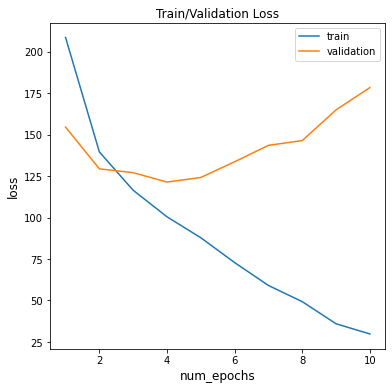

In [34]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.64      0.33      0.44       208
                 displaced_people_and_evacuations       0.55      0.42      0.48       114
donation_needs_or_offers_or_volunteering_services       0.60      0.85      0.70       596
              infrastructure_and_utilities_damage       0.76      0.48      0.59       283
                           injured_or_dead_people       0.86      0.87      0.87       545
                  missing_trapped_or_found_people       0.37      0.49      0.42        82
                        not_related_or_irrelevant       0.60      0.57      0.59       429
                         other_useful_information       0.67      0.69      0.68      1025
                   sympathy_and_emotional_support       0.78      0.66      0.72       384

                                         accuracy                           0.68      36

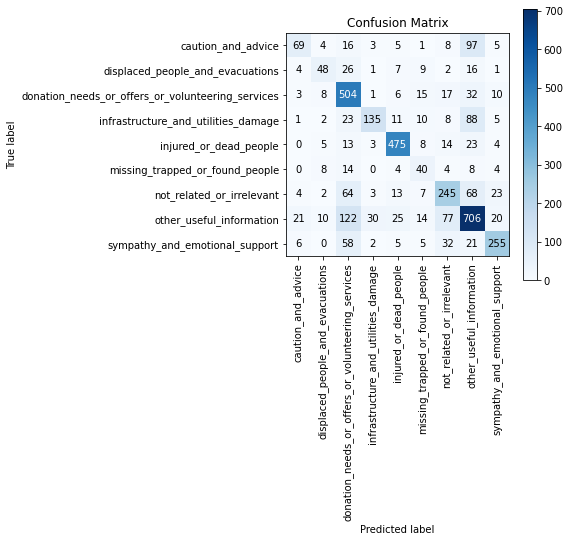

In [35]:
conf_matrix(val_preds)